In [87]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [88]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [89]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [90]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss by MSE

    e = y - tx @ w
    return np.mean(np.abs(e))
    
    # ***************************************************
    #raise NotImplementedError

In [91]:
w = np.array([1, 1])
a = compute_loss(y,tx,w)
print(a)

72.29392200210518


# 2. Grid Search

Fill in the function `grid_search()` below:

In [92]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss for each combination of w0 and w1.

        # Create a meshgrid for w0 and w1
    W0, W1 = np.meshgrid(grid_w0, grid_w1)
    
    # Stack W0 and W1 to create a (2, num_grid_pts_w0 * num_grid_pts_w1) array of weights
    W = np.vstack([W0.ravel(), W1.ravel()]).T  # Shape will be (num_grid_pts_w0 * num_grid_pts_w1, 2)

    # Compute the predictions for all weights
    predictions = tx @ W.T  # Shape will be (N, num_grid_pts_w0 * num_grid_pts_w1)

    # Compute the errors
    errors = y[:, np.newaxis] - predictions  # Shape will be (N, num_grid_pts_w0 * num_grid_pts_w1)

    # Compute the MSE for all combinations and reshape it back to (num_grid_pts_w0, num_grid_pts_w1)
    losses = 0.5 * np.mean(errors ** 2, axis=0).reshape(W0.shape)

    return losses
    # ***************************************************
    raise NotImplementedError
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=20.759339381144255, w0*=65.51724137931035, w1*=25.86206896551724, execution time=0.129 seconds


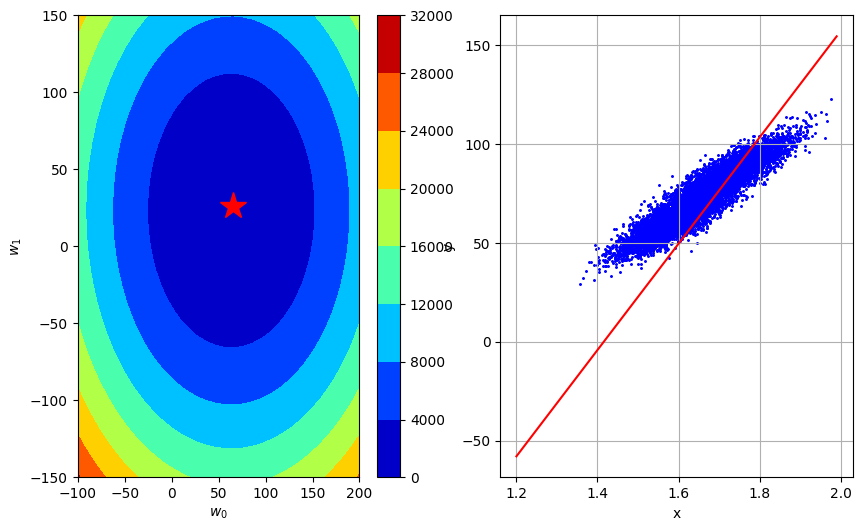

In [93]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=30)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [94]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute gradient vector
    # Number of samples
    N = y.shape[0]

    # Compute the predictions
    predictions = tx @ w  # Shape (N,)

    # Compute the errors
    errors = y - predictions  # Shape (N,)

    # Compute the gradient
    gradient = - (1 / N) * (tx.T @ errors)  # Shape (2,)

    return gradient
    
    # ***************************************************
    raise NotImplementedError

Please fill in the functions `gradient_descent` below:

In [95]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute gradient and loss

        gradient = compute_gradient(y,tx,w)
        loss = compute_loss(y,tx,w)
        # ***************************************************
       # raise NotImplementedError
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by gradient
        w = w - gamma*gradient

        # ***************************************************
        #raise NotImplementedError

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [96]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=73.29392200210518, w0=51.30574540147368, w1=9.43579870449234
GD iter. 1/49: loss=21.98888659235387, w0=66.69746902191575, w1=12.266538315840016
GD iter. 2/49: loss=7.265302114604075, w0=71.31498610804836, w1=13.115760199244333
GD iter. 3/49: loss=4.699945676696624, w0=72.70024123388815, w1=13.370526764265632
GD iter. 4/49: loss=4.447409765322355, w0=73.11581777164008, w1=13.446956733772025
GD iter. 5/49: loss=4.426368339890847, w0=73.24049073296565, w1=13.469885724623941
GD iter. 6/49: loss=4.424908541814049, w0=73.27789262136334, w1=13.476764421879516
GD iter. 7/49: loss=4.42494113435403, w0=73.28911318788263, w1=13.478828031056189
GD iter. 8/49: loss=4.424986760372248, w0=73.29247935783842, w1=13.47944711380919
GD iter. 9/49: loss=4.425002951094766, w0=73.29348920882515, w1=13.47963283863509
GD iter. 10/49: loss=4.42500808460945, w0=73.29379216412117, w1=13.479688556082861
GD iter. 11/49: loss=4.425009648774414, w0=73.29388305071, w1=13.479705271317192
GD iter. 12

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

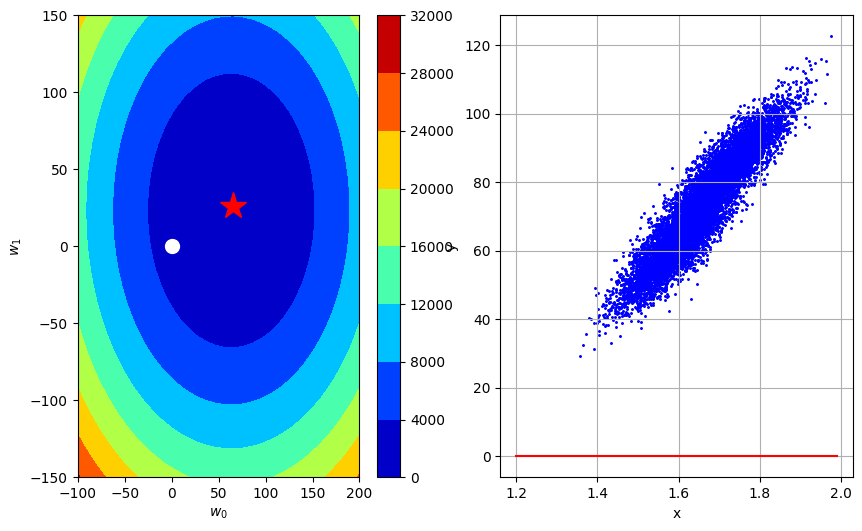

In [97]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 4. Stochastic gradient descent

In [98]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """

    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: implement stochastic gradient computation. It's the same as the usual gradient.

    gradient = compute_gradient(y,tx,w)
    return gradient
    # ***************************************************
    #raise NotImplementedError


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic gradient descent.
        
        batch_indices = np.random.choice(y.shape[0], batch_size, replace = False)
        x_batch = tx[batch_indices]
        y_batch = y[batch_indices]

        gradient = compute_stoch_gradient(y_batch,x_batch, w)
        loss = compute_loss(y_batch, x_batch, w)

        w = w - gamma*gradient

        losses.append(loss)
        ws.append(w)

        # ***************************************************
        #raise NotImplementedError

        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [99]:
w_100_20 = np.array([100,20])
w_50_10 = np.array([50,10])

gradient_100_20 = compute_stoch_gradient(y,tx, w_100_20)
gradient_50_10 = compute_stoch_gradient(y,tx, w_50_10)

print("gradient_100_20=", gradient_100_20)
print("gradient_50_10=", gradient_50_10)

gradient_100_20= [26.706078    6.52028757]
gradient_50_10= [-23.293922    -3.47971243]


In [100]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=83.67950405156856, w0=8.367950405156856, w1=6.485483782245978
SGD iter. 1/49: loss=77.84542532729932, w0=16.15249293788679, w1=10.03690143442473
SGD iter. 2/49: loss=47.95112494445977, w0=20.947605432332768, w1=6.921659204139313
SGD iter. 3/49: loss=46.99483752265219, w0=25.647089184597988, w1=5.64802320557485
SGD iter. 4/49: loss=52.71931044713389, w0=30.91902022931138, w1=12.575242151741987
SGD iter. 5/49: loss=38.115834834718456, w0=34.73060371278322, w1=16.55807041170299
SGD iter. 6/49: loss=51.693676126892655, w0=39.899971325472485, w1=9.104606726629566
SGD iter. 7/49: loss=25.44837938450184, w0=42.44480926392267, w1=13.067175733998585
SGD iter. 8/49: loss=23.512176485172496, w0=44.79602691243992, w1=12.938880499316053
SGD iter. 9/49: loss=16.282223225506506, w0=46.42424923499057, w1=12.369356284411808
SGD iter. 10/49: loss=39.86496527853853, w0=50.41074576284442, w1=10.265134870104317
SGD iter. 11/49: loss=28.9348875208306, w0=53.30423451492748, w1=12.5952911

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

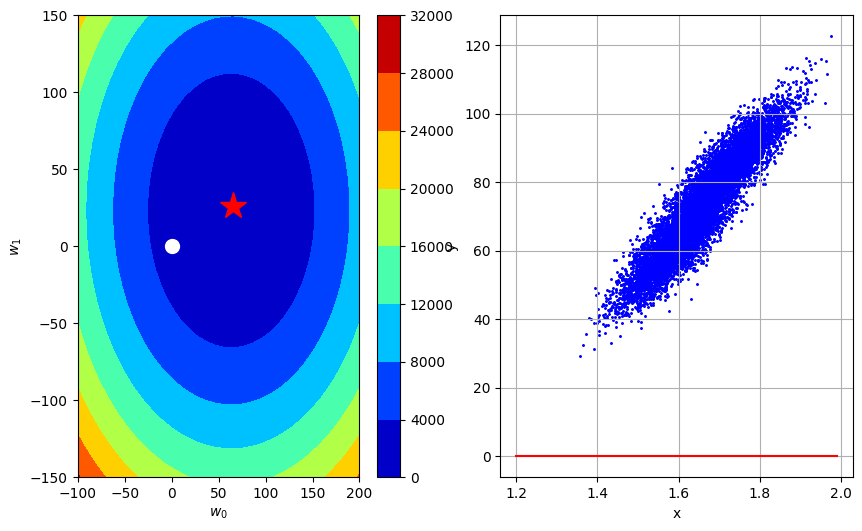

In [101]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

# 5. Effect of Outliers and MAE Cost Function

In [102]:
import datetime
from helpers import *

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: reload the data by subsampling first, then by subsampling and adding outliers

import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)
# ***************************************************
#raise NotImplementedError

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [103]:
y.shape, tx.shape

((202,), (202, 2))

In [104]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points
#       and the model fit

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))
# ***************************************************
#raise NotImplementedError


end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=58.317030711461854, w0=40.82192149802329, w1=-36.217883689318015
SGD iter. 1/49: loss=5.292019038244163, w0=44.526334824794205, w1=-38.20549109602543
SGD iter. 2/49: loss=32.483744072766434, w0=21.787713973857702, w1=-12.223994229199466
SGD iter. 3/49: loss=37.44375116888993, w0=47.99833979208066, w1=-35.40696159095462
SGD iter. 4/49: loss=41.20492441144433, w0=19.154892704069628, w1=1.7447277110924446
SGD iter. 5/49: loss=36.76909882100304, w0=44.89326187877175, w1=-14.131896269986331
SGD iter. 6/49: loss=9.30538747408184, w0=38.37949064691446, w1=-6.51396293004478
SGD iter. 7/49: loss=6.117647885439013, w0=42.66184416672177, w1=-11.52222657498313
SGD iter. 8/49: loss=58.30786692091562, w0=83.47735101136271, w1=26.49782022595668
SGD iter. 9/49: loss=33.790382368073594, w0=59.8240833537112, w1=-5.498707167337425
SGD iter. 10/49: loss=8.098533402476, w0=65.4930567354444, w1=-8.705533999656396
SGD iter. 11/49: loss=23.85607429250512, w0=48.793804730690816, w1=14.5970

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

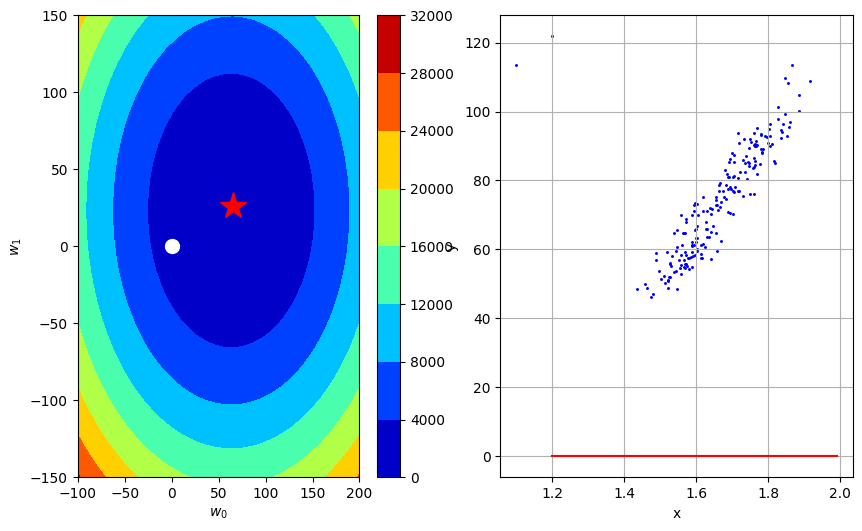

In [105]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 6. Subgradient descent

In [106]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute subgradient gradient vector for MAE

    """Compute a subgradient of the MAE at w."""
    # Compute the residuals
    residuals = y - tx.dot(w)
    
    # Compute the sign of the residuals
    signs = np.sign(residuals)
    loss = compute_loss(y,tx,w)
    
    # Compute the subgradient as the average over all data points
    subgradient = -tx.T.dot(signs) / len(y)
    print("From compute_subgradient_mae function: subgradient =",subgradient)
    
    return subgradient
    # ***************************************************
    #raise NotImplementedError

In [107]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute subgradient and loss
        subgradient = compute_subgradient_mae(y, tx, w)

        # Compute loss (MAE)
        loss = np.mean(np.abs(y - tx.dot(w)))

        # Update w by subgradient
        w = w - gamma * subgradient

        # Store current values of w and loss
        ws.append(w)
        losses.append(loss)
        # ***************************************************
        #raise NotImplementedError
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by subgradient
        # ***************************************************
        #raise NotImplementedError

        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [108]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y,tx,w,max_iters,gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

From compute_subgradient_mae function: subgradient = [-1.00000000e+00 -1.25092456e-15]
SubGD iter. 0/499: loss=73.06780585492638, w0=1.7, w1=1.0000000000000009
From compute_subgradient_mae function: subgradient = [-1.00000000e+00 -1.25092456e-15]
SubGD iter. 1/499: loss=72.36780585492637, w0=2.4, w1=1.0000000000000018
From compute_subgradient_mae function: subgradient = [-1.00000000e+00 -1.25092456e-15]
SubGD iter. 2/499: loss=71.66780585492639, w0=3.0999999999999996, w1=1.0000000000000027
From compute_subgradient_mae function: subgradient = [-1.00000000e+00 -1.25092456e-15]
SubGD iter. 3/499: loss=70.96780585492638, w0=3.8, w1=1.0000000000000036
From compute_subgradient_mae function: subgradient = [-1.00000000e+00 -1.25092456e-15]
SubGD iter. 4/499: loss=70.26780585492638, w0=4.5, w1=1.0000000000000044
From compute_subgradient_mae function: subgradient = [-1.00000000e+00 -1.25092456e-15]
SubGD iter. 5/499: loss=69.56780585492638, w0=5.2, w1=1.0000000000000053
From compute_subgradient_

interactive(children=(IntSlider(value=1, description='n_iter', max=1001, min=1), Output()), _dom_classes=('wid…

<function __main__.plot_figure(n_iter)>

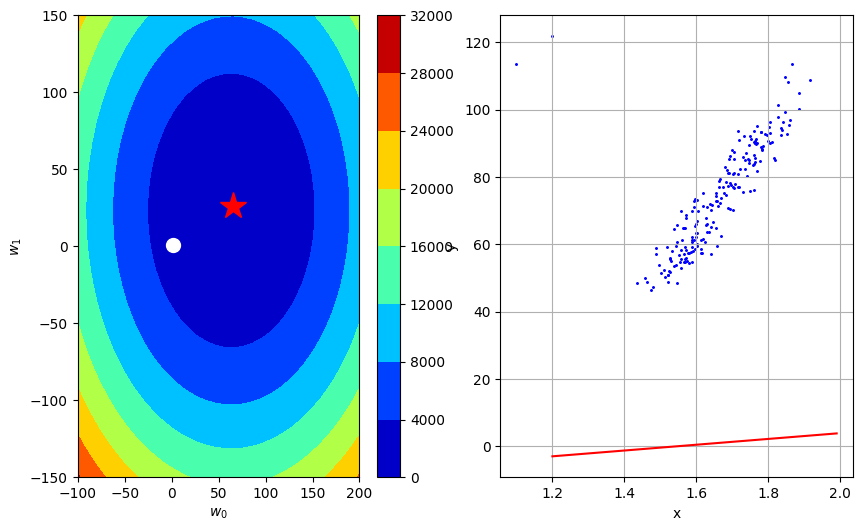

In [109]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [110]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic subgradient descent.
        subgradient = compute_subgradient_mae(y,tx, w)

        # Compute loss (MAE) for the full dataset
        loss = np.mean(np.abs(y - tx.dot(w)))

        # Update w by subgradient
        w = w - gamma * subgradient

        # Store current values of w and loss
        ws.append(w)
        losses.append(loss)
        # ***************************************************
       # raise NotImplementedError

        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [111]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

From compute_subgradient_mae function: subgradient = [-1.00000000e+00 -1.25092456e-15]
SubSGD iter. 0/499: loss=74.06780585492638, w0=0.7, w1=8.756471895211877e-16
From compute_subgradient_mae function: subgradient = [-1.00000000e+00 -1.25092456e-15]
SubSGD iter. 1/499: loss=73.36780585492637, w0=1.4, w1=1.7512943790423754e-15
From compute_subgradient_mae function: subgradient = [-1.00000000e+00 -1.25092456e-15]
SubSGD iter. 2/499: loss=72.66780585492637, w0=2.0999999999999996, w1=2.626941568563563e-15
From compute_subgradient_mae function: subgradient = [-1.00000000e+00 -1.25092456e-15]
SubSGD iter. 3/499: loss=71.96780585492637, w0=2.8, w1=3.502588758084751e-15
From compute_subgradient_mae function: subgradient = [-1.00000000e+00 -1.25092456e-15]
SubSGD iter. 4/499: loss=71.26780585492638, w0=3.5, w1=4.378235947605939e-15
From compute_subgradient_mae function: subgradient = [-1.00000000e+00 -1.25092456e-15]
SubSGD iter. 5/499: loss=70.56780585492638, w0=4.2, w1=5.253883137127127e-15


interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

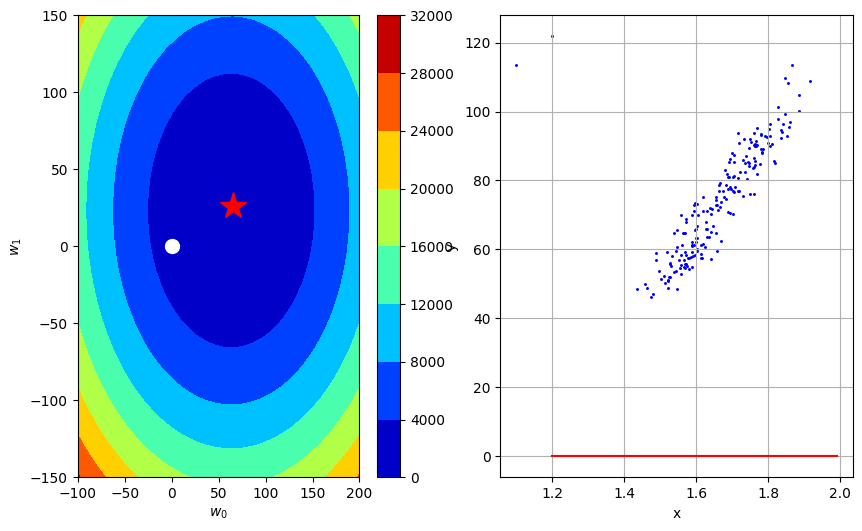

In [112]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))